# Process Mining Module - PDEng program Data Science

This notebook is part of the Process Mining module of the JADS PDEng program on Data Science. The collection of notebooks is a *living document* and subject to change. 

# Hands-on 4 - 'Predictive Process Mining' (Python / PM4Py)

* **Responsible Lecturer**: Dr. Felix Mannhardt, [@fmannhardt](https://twitter.com/fmannhardt)
* **Last Update**: 19th May 2021

## Setup

<img src="https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png" alt="PM4Py" style="width: 200px;"/>

In this notebook, we are using the following libraries: 

* [numpy](https://numpy.org/)
* [pandas](https://pandas.pydata.org/)
* [PM4Py library](https://pm4py.fit.fraunhofer.de/)
* [PyTorch](https://pytorch.org/)

In [44]:
## Perform the commented out commands to install the dependencies
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install pm4py
# %pip install pytorch

In [289]:
import numpy as np
import pandas as pd
import pm4py
import os
import torch
import torch.nn as nn
from tqdm import tqdm

## Event Log

In [573]:
sepsis = pd.read_csv("../data/sepsis.csv", sep=';')
sepsis_log = pm4py.format_dataframe(sepsis, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
sepsis_log = pm4py.convert_to_event_log(sepsis_log)

In [204]:
len(sepsis_log)

1050

## Feature Extraction / Encoding

We are using the PM4Py functionality here:

https://pm4py.fit.fraunhofer.de/documentation/1.5#item-7-0-1

### Set of Events / 2-grams

In [512]:
data, feature_names = get_log_representation.get_representation(sepsis_log, 
                                                                str_ev_attr=["concept:name"],
                                                                str_tr_attr=[],
                                                                num_ev_attr=[],
                                                                num_tr_attr=[],
                                                                str_evsucc_attr=[])

In [513]:
feature_names

['event:concept:name@Admission IC',
 'event:concept:name@Admission NC',
 'event:concept:name@CRP',
 'event:concept:name@ER Registration',
 'event:concept:name@ER Sepsis Triage',
 'event:concept:name@ER Triage',
 'event:concept:name@IV Antibiotics',
 'event:concept:name@IV Liquid',
 'event:concept:name@LacticAcid',
 'event:concept:name@Leucocytes',
 'event:concept:name@Release A',
 'event:concept:name@Release B',
 'event:concept:name@Release C',
 'event:concept:name@Release D',
 'event:concept:name@Release E',
 'event:concept:name@Return ER']

In [514]:
data[0]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [515]:
data.shape

(1050, 16)

So, PM4Py gives us a *one-hot encoding* of the so called *set abstraction* of the event log. This means there are 16 distinct activities in the event log and the feature vector simply encodes whether that activity is present or not in the data. 

Let us have a look at the distribution of these feature vectors:

In [516]:
dist_features = np.unique(data, return_counts= True, axis = 0)
dist_features

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 1]]),
 array([ 35,   2,  63,  23,   3,   8,   7,  99,   2,   3,   1,   1,   1,
          2,   2,   2,   2,  28,  11,   2,   1,   1,   2,   6,  14,  13,
          4,   1,   1,   2,   1,   3,  23,  16,   3,  10,   5,  21,   1,
          9,   5,  14,   5,  29, 267, 186,   1,   1,   3,   4,   1,   1,
          1,   2,   4,   8,   1,   1,   1,   2,   3,   1,   6,  31,  38],
       dtype=int64))

What is the most common feature vector?

In [517]:
dist_features[0][np.argmax(dist_features[1])]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

Makes sense, almost all activities actually are bound to occur in this process. There are only few choices.
So, this encoding is likely not the most useful one but let's anyway try to use it for an initial predictive model and iterate later.

## Bag of Words / Multiset

In [574]:
print(sepsis.loc[:,["case_id"]].nunique())
data = np.asarray(sepsis.loc[:,["case_id", "activity"]].groupby(["case_id", "activity"]).size().unstack(fill_value=0))
data.shape

case_id    1049
dtype: int64


(1049, 16)

## Prediction

### Throughput time

In [562]:
from pm4py.statistics.traces.log import case_statistics
durations = np.asarray(case_statistics.get_all_casedurations(sepsis_log, parameters={ case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"} ))
durations = np.expand_dims(durations, 1)
len(durations)
durations = durations / 60 / 60 / 24

<AxesSubplot:>

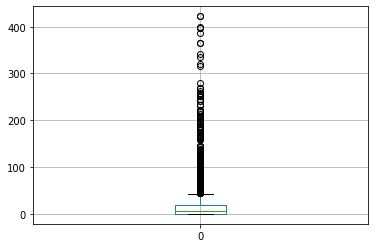

In [563]:
pd.DataFrame(durations).boxplot()

In [564]:
from torch.utils.data import TensorDataset, DataLoader

data = data.astype('float32')
durations = durations.astype('float32')

print(data.shape)
print(durations.shape)

ds = TensorDataset(torch.from_numpy(data), 
                   torch.from_numpy(durations))
train_dataloader = DataLoader(ds, batch_size=64, shuffle=True)

(1049, 16)
(1050, 1)


AssertionError: Size mismatch between tensors

Let's define a simple network and try to overfit:

In [525]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(            
            torch.nn.Linear(16, 512),
            nn.ReLU(),
            torch.nn.Linear(512, 256),
            nn.ReLU(),
            torch.nn.Linear(256, 128),
            nn.ReLU(),            
            torch.nn.Linear(128, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [526]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [527]:
def train(dataloader, model, loss_fn, measure_fn, optimizer, epochs, print_interval = 10):
    
    losses = []
    size = len(dataloader.dataset)
    
    for epoch in range(epochs):    
        
        loop = tqdm(dataloader)

        for batch, (X, y) in enumerate(loop):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            
            loss = loss_fn(pred, y)
            measure = measure_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append([loss.item(), measure.item()])

            loop.set_description('Epoch {}/{}'.format(epoch + 1, epochs))
            loop.set_postfix(loss=loss.item(), measure=measure.item())
    
    return losses

In [528]:
loss_fn = nn.MSELoss()
measure_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

results = train(train_dataloader, model, loss_fn, measure_fn, optimizer, 500)
print("Done!")

Epoch 500/500: 100%|██████████████████████████████████████| 17/17 [00:00<00:00, 121.43it/s, loss=5.88e+3, measure=43.1]


Done!


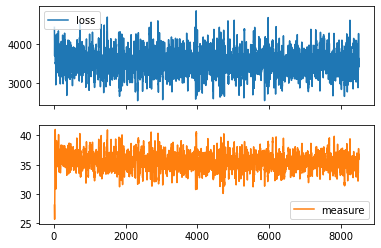

In [530]:
results_data = pd.DataFrame(results).rolling(window=15).mean()
results_data.columns = ['loss', 'measure']
ax = results_data.plot(subplots=True);